In [85]:
%matplotlib inline 
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange
from collections import defaultdict

# Training

In [33]:
# connect to database
dbname = 'imagenet'
collname_rot = 'rotation' # TODO need to iterate for other nets in pt. 1
collname_mul = 'multitask'
collname_clf = 'alexnet'
port = 24444
expid = 'exp2'
expid2 = 'experiment_1'

conn = pm.MongoClient(port = port)
conn2 = pm.MongoClient(port = port, host = '104.196.242.101')
coll_rot = conn[dbname][collname_rot + '.files']
coll_mul = conn[dbname][collname_mul + '.files']
coll_clf = conn2[dbname][collname_clf + '.files']

In [35]:
def get_losses(exp_id, coll):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])


def get_boxcar(num_pts, total_length):
    my_ones = np.ones(num_pts)/num_pts
    return np.hstack([my_ones])

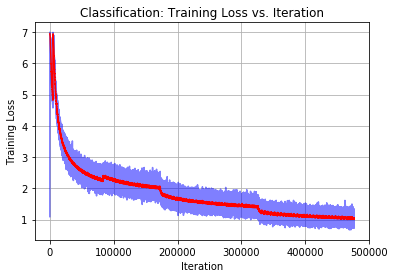

In [36]:
ydict['losses'] = get_losses(expid2, coll_clf)
smoothing_num = 100;
my_box = get_boxcar(smoothing_num, ydict['losses'].shape[0])
ydict['smooth' + str(smoothing_num)] = signal.convolve(ydict['losses'],my_box)

plt.plot(ydict['losses'], color="blue", alpha=0.5)
plt.plot(ydict['smooth' + str(smoothing_num)][smoothing_num:-smoothing_num], color="red")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("Classification: Training Loss vs. Iteration")
plt.grid()

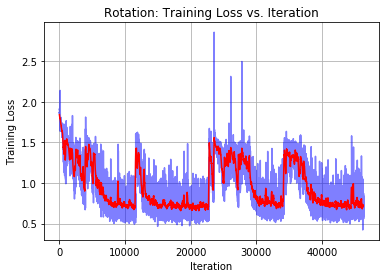

In [10]:
ydict = {}
ydict['losses'] = get_losses(expid, coll_rot)[-53000:]
smoothing_num = 100;
my_box = get_boxcar(smoothing_num, ydict['losses'].shape[0])
ydict['smooth' + str(smoothing_num)] = signal.convolve(ydict['losses'],my_box)

plt.plot(ydict['losses'], color="blue", alpha=0.5)
plt.plot(ydict['smooth' + str(smoothing_num)][smoothing_num:-smoothing_num], color="red")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("Rotation: Training Loss vs. Iteration")
plt.grid()

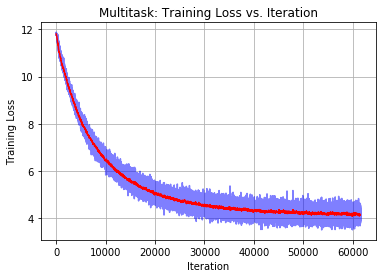

In [11]:
ydict['losses'] = get_losses(expid, coll_mul)
smoothing_num = 100;
my_box = get_boxcar(smoothing_num, ydict['losses'].shape[0])
ydict['smooth' + str(smoothing_num)] = signal.convolve(ydict['losses'],my_box)

plt.plot(ydict['losses'], color="blue", alpha=0.5)
plt.plot(ydict['smooth' + str(smoothing_num)][smoothing_num:-smoothing_num], color="red")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("Multitask: Training Loss vs. Iteration")
plt.grid()

In [12]:
def get_val(exp_id, coll):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val)#, projection = ['validation_results'])
    val_results = defaultdict(list)
    for i in range(val_steps.count()):
        #print val_steps[i]['step']#.keys()
        val_results['step'].append(val_steps[i]['step'])
        for k,v in val_steps[i]['validation_results']['topn_val'].iteritems():
            val_results[k].append(v)
    return val_results

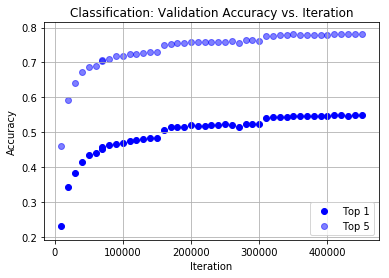

In [37]:
val_results = get_val(expid2, coll_clf)

plt.scatter(val_results['step'],val_results['top1'], color="blue", label='Top 1')
plt.scatter(val_results['step'],val_results['top5'], color="blue", label='Top 5', alpha =0.5)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Classification: Validation Accuracy vs. Iteration")
plt.legend()
plt.grid()

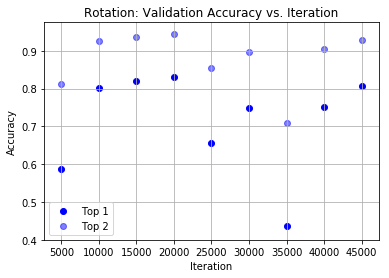

In [38]:
val_results = get_val(expid, coll_rot)

plt.scatter(val_results['step'],val_results['top1'], color="blue", label='Top 1')
plt.scatter(val_results['step'],val_results['top2'], color="blue", label='Top 2', alpha =0.5)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Rotation: Validation Accuracy vs. Iteration")
plt.legend()
plt.grid()

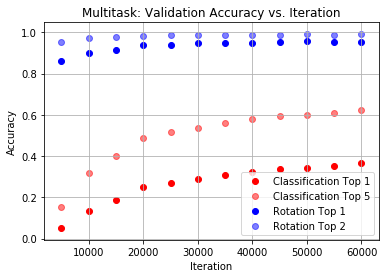

In [39]:
val_results = get_val(expid, coll_mul)

plt.scatter(val_results['step'],val_results['top1_clf'], color="red", label='Classification Top 1')
plt.scatter(val_results['step'],val_results['top5_clf'], color="red", label='Classification Top 5', alpha =0.5)
plt.scatter(val_results['step'],val_results['top1_rot'], color="blue", label='Rotation Top 1')
plt.scatter(val_results['step'],val_results['top2_rot'], color="blue", label='Rotation Top 2', alpha =0.5)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Multitask: Validation Accuracy vs. Iteration")
plt.grid()
plt.legend()

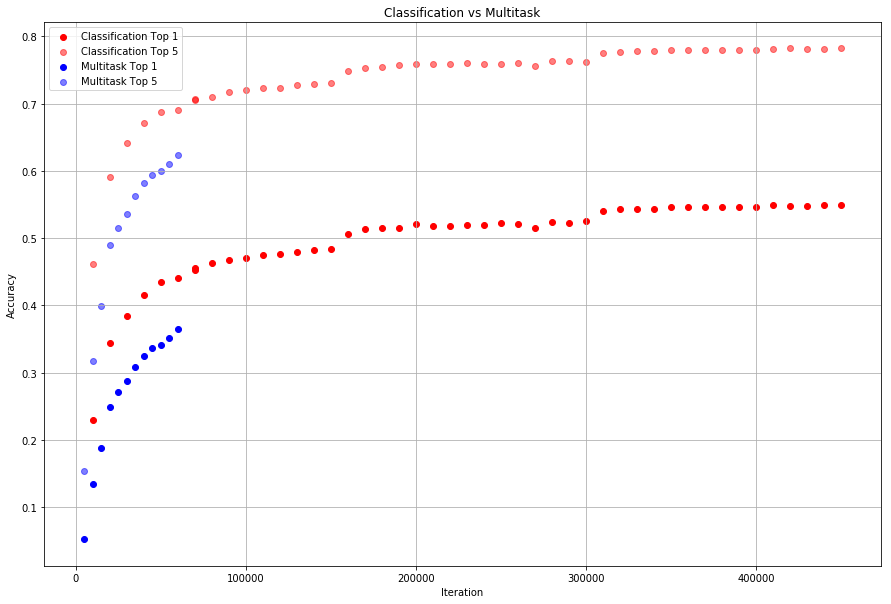

In [136]:
val_results1 = get_val(expid, coll_mul)
val_results2 = get_val(expid2, coll_clf)

plt.scatter(val_results2['step'],val_results2['top1'], color="red", label='Classification Top 1')
plt.scatter(val_results2['step'],val_results2['top5'], color="red", label='Classification Top 5', alpha =0.5)
plt.scatter(val_results1['step'],val_results1['top1_clf'], color="blue", label='Multitask Top 1')
plt.scatter(val_results1['step'],val_results1['top5_clf'], color="blue", label='Multitask Top 5', alpha =0.5)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Classification vs Multitask")
plt.grid()
plt.legend()

# Testing

In [76]:
def get_test_results(coll,exp_id, modelname):
    q_val = {
             'validation_results' : {'$exists' : True}, 
             'validates' : {'$exists' : True},
    }
    val_steps = coll.find(q_val)#, projection = ['validation_results'])
    val_results = defaultdict(list)
    #print val_steps[0].keys()
    for i in range(val_steps.count()):
        #print val_steps[i]['validation_results']['valid0'].keys()
        if 'V0V3V6' not in val_steps[i]['exp_id']: continue
        start = len(exp_id + '_')
        end = val_steps[i]['exp_id'].find('_' + modelname + '_V0V3V6')
        #print start, end
        val_results['step'].append(int(val_steps[i]['exp_id'][start:end]))
        for k,v in val_steps[i]['validation_results']['valid0'].iteritems():
            val_results[k].append(v)
    return val_results

### Note: here should be the crap for alexnet directly from the training, but I fucked up the tests.

In [86]:
df = pd.read_csv('alexnet_results.csv')
layers = df['Layer'].unique()
pool5 = df[df['Layer'] == 'pool5']

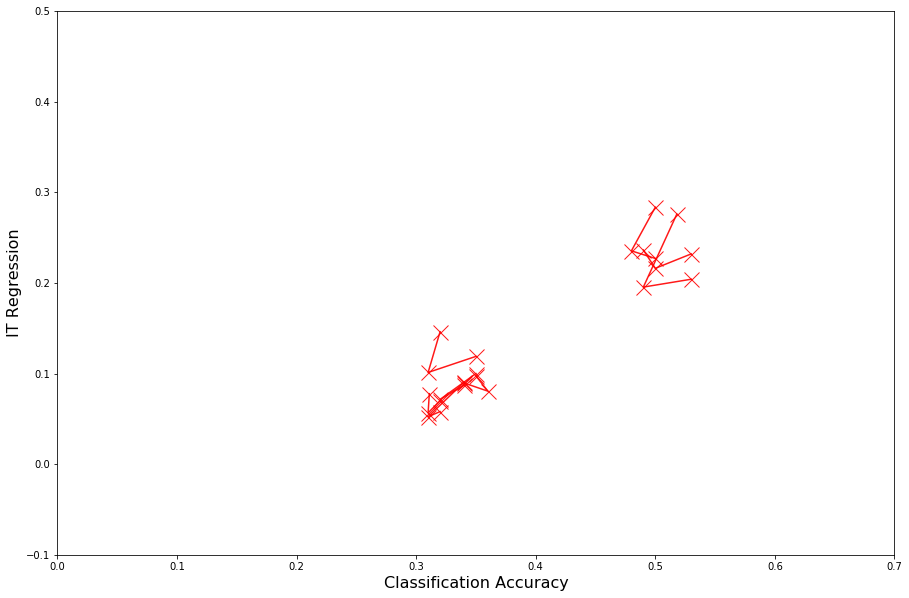

In [135]:
plt.rcParams["figure.figsize"] = (15,10)
for layer in layers:
    dflayer =  df[df['Layer'] == layer]
    plt.plot(dflayer['Accuracy'], dflayer['IT'], marker='x', 
             markersize = 15, alpha=0.9, label=layer, color = 'red')

#plt.xlim(0,0.8)
plt.ylim(-0.1,0.5)
plt.xlim(0.0,0.7)
#plt.legend(fontsize=16);
plt.ylabel('IT Regression',fontsize=16)
plt.xlabel('Classification Accuracy',fontsize=16)

In [100]:
target_layers = [
            #'conv1',
            'pool1',
            #'conv2',
            #'pool2',
            #'conv3',
            #'conv4',
            'conv5',
            'pool5',
            'fc6',
            'fc7',
            #'fc8',
            ]
target_layers_mul = [
            #'conv1',
            'pool1',
            #'conv2',
            #'pool2',
            #'conv3',
            #'conv4',
            'conv5',
            'pool5',
            'fc6_rot',
            'fc7_rot',
            'fc6_clf',
            'fc7_clf',
            #'fc8',
            ]

In [98]:
test_results_rot = get_test_results(coll_rot, expid, collname_rot)
test_results_mul = get_test_results(coll_mul, expid, collname_mul)

In [107]:
# get the it_regression for each target layer
# get the accuracy for each layer
def get_results_by_layer(target_layers, result_dict):
    it_results = defaultdict(list)
    acc_results = defaultdict(list)
    for layer in target_layers:
        #get it_regression
        it_results[layer] = [1 - result['noise_corrected_multi_rsquared_loss'] for result in result_dict['it_regression_'+layer]]
        acc_results[layer] = [(np.mean(result['result_summary']['accbal']) - .5) * 2 for result in result_dict['categorization_'+layer]]
    return it_results, acc_results

In [108]:
it_mul, cat_mul = get_results_by_layer(target_layers_mul, test_results_mul)
it_rot, cat_rot = get_results_by_layer(target_layers, test_results_rot)

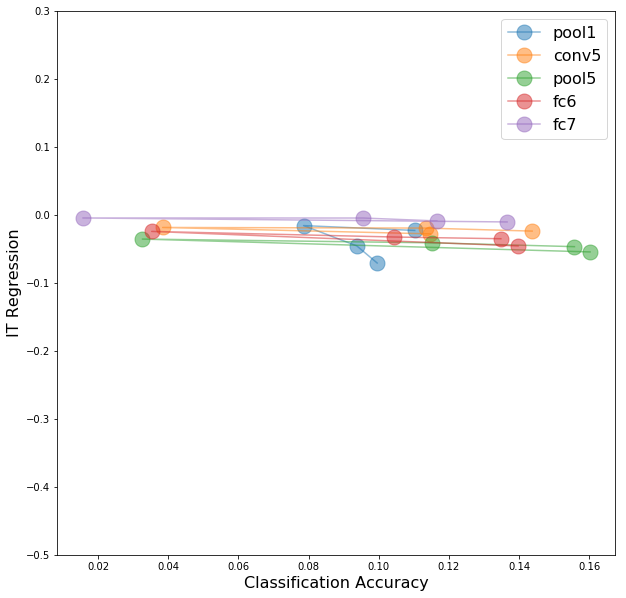

In [113]:
# rot
for layer in target_layers:
    plt.plot(cat_rot[layer], it_rot[layer], marker='o', 
             markersize = 15, alpha=0.5, label=layer)
#plt.xlim(0,0.8)
plt.ylim(-0.5,0.3)
plt.legend(fontsize=16);
plt.ylabel('IT Regression',fontsize=16)
plt.xlabel('Classification Accuracy',fontsize=16)

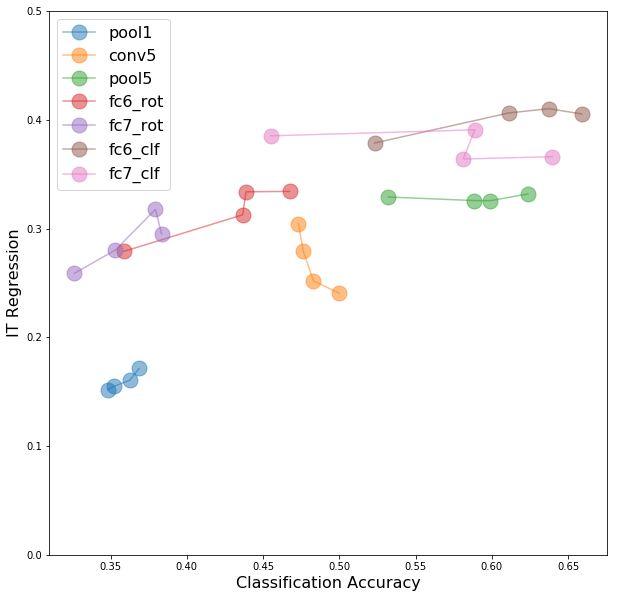

In [115]:
# mul
for layer in target_layers_mul:
    plt.plot(cat_mul[layer], it_mul[layer], marker='o', 
             markersize = 15, alpha=0.5, label=layer)
#plt.xlim(0,0.8)
plt.ylim(0,0.5)
plt.legend(fontsize=16);
plt.ylabel('IT Regression',fontsize=16)
plt.xlabel('Classification Accuracy',fontsize=16)

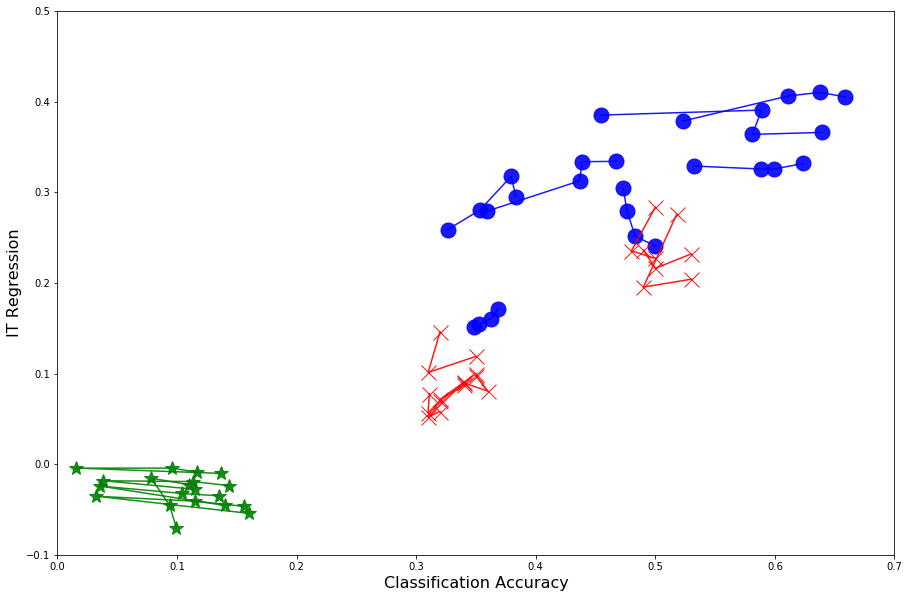

In [134]:
# mul
for layer in target_layers_mul:
    plt.plot(cat_mul[layer], it_mul[layer], marker='o', 
             markersize = 15, alpha=0.9, color = 'blue', label='Multitask: '+layer)

for layer in layers:
    dflayer =  df[df['Layer'] == layer]
    plt.plot(dflayer['Accuracy'], dflayer['IT'], marker='x', 
             markersize = 15, alpha=0.9, color='red', label='Classification: '+layer)

for layer in target_layers:
    plt.plot(cat_rot[layer], it_rot[layer], marker='*', 
             markersize = 15, alpha=0.9, color = 'green', label='Rotation: '+layer)

#plt.xlim(0,0.8)
plt.ylim(-0.1,0.5)
plt.xlim(0.0,0.7)
#plt.legend(fontsize=8);
plt.ylabel('IT Regression',fontsize=16)
plt.xlabel('Classification Accuracy',fontsize=16)